In [ ]:
#Token-Based Parsing

In [19]:
import pandas as pd

def parse_tcpdump_file(file_path):
    rows = []

    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()

            if len(parts) >= 12 and 'TCP' in parts:
                try:
                    time = float(parts[1])
                    src = parts[2]
                    dst = parts[4]
                    src_port = parts[5]
                    dst_port = parts[7]
                    flags_raw = " ".join(parts[8:])
                    # Extract TCP flags between square brackets
                    flags_match = flags_raw.split('[')
                    if len(flags_match) > 1:
                        flags = flags_match[1].split(']')[0]
                    else:
                        flags = "UNKNOWN"

                    rows.append({
                        'time': time,
                        'src': src,
                        'dst': dst,
                        'src_port': src_port,
                        'dst_port': dst_port,
                        'flags': flags
                    })
                except Exception as e:
                    print("Skipped line due to parse error:", line)
                    continue

    return pd.DataFrame(rows)


In [23]:
df = parse_tcpdump_file("tcpdump.txt")
print(df.head())
print(df.columns)
print(f"Parsed {len(df)} rows")


       time                                      src                      dst  \
0  0.000000                             20.52.64.201              192.168.1.8   
1  2.880997                              192.168.1.8              20.42.73.31   
2  2.881239  2401:4900:8840:b020:556f:99ec:de73:e6dd  2600:1417:56::174c:9d09   
3  2.881485                              192.168.1.8           204.79.197.222   
4  2.881591                              192.168.1.8            13.107.18.254   

  src_port dst_port     flags  
0      TCP      443  RST, ACK  
1      TCP    53202  FIN, ACK  
2      TCP    53200  FIN, ACK  
3      TCP    53208  FIN, ACK  
4      TCP    53205  FIN, ACK  
Index(['time', 'src', 'dst', 'src_port', 'dst_port', 'flags'], dtype='object')
Parsed 94 rows


In [ ]:
#Encode TCP Flags

In [25]:
from sklearn.preprocessing import LabelEncoder

df['flag_encoded'] = LabelEncoder().fit_transform(df['flags'])


In [1]:
#Convert Time into Bins (Time Buckets) 
# divide into 10 equal time bins

In [27]:
df['time_bin'] = pd.cut(df['time'], bins=10)  


In [30]:
df['time_rounded'] = df['time'].astype(float).round(0)


In [ ]:
#Visualize TCP Flag Frequency Over Time

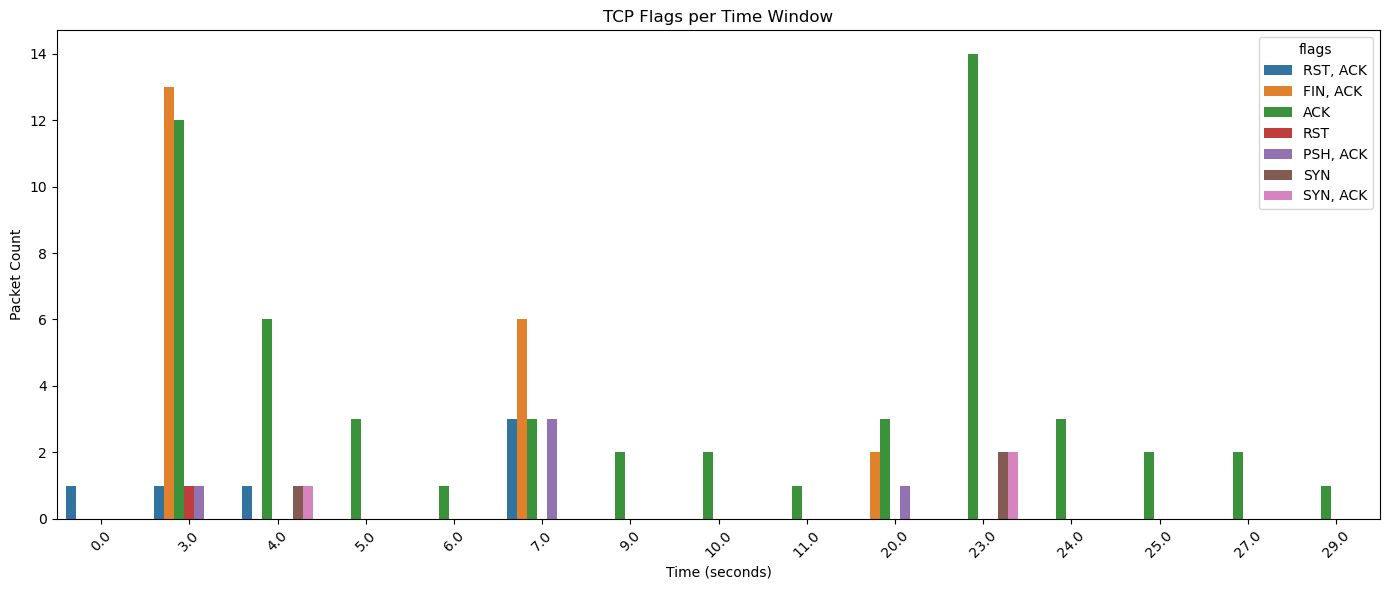

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
sns.countplot(data=df, x='time_rounded', hue='flags')
plt.xticks(rotation=45)
plt.title("TCP Flags per Time Window")
plt.ylabel("Packet Count")
plt.xlabel("Time (seconds)")
plt.tight_layout()
plt.show()


In [ ]:
#Train ML Model

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df[['time']] 
y = df['flag_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print("Accuracy:", clf.score(X_test, y_test))


Accuracy: 0.5263157894736842


In [ ]:
#One-Hot Encode TCP Flags

In [36]:
flags_dummies = df['flags'].str.get_dummies(sep=', ')
df = pd.concat([df, flags_dummies], axis=1)


In [ ]:
#Categorize Port Numbers

In [38]:
def categorize_port(port):
    try:
        port = int(port)
        if port in [80, 443, 21, 22, 23, 25]:
            return 'well_known'
        elif port < 1024:
            return 'system'
        elif port < 49152:
            return 'user'
        else:
            return 'dynamic'
    except:
        return 'unknown'

df['src_port_cat'] = df['src_port'].apply(categorize_port)
df['dst_port_cat'] = df['dst_port'].apply(categorize_port)


In [40]:
df = pd.get_dummies(df, columns=['src_port_cat', 'dst_port_cat'])


In [ ]:
#Direction: Internal → External or External → Internal

In [42]:
def classify_direction(src, dst):
    if '192.168.1.8' in src:
        return 'outbound'
    elif '192.168.1.8' in dst:
        return 'inbound'
    else:
        return 'external'

df['direction'] = df.apply(lambda row: classify_direction(row['src'], row['dst']), axis=1)
df = pd.get_dummies(df, columns=['direction'])


In [ ]:
#Time of Day Feature

In [44]:
def time_of_day(seconds):
    hour = int(seconds) % 86400 // 3600
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

df['timeofday'] = df['time'].apply(time_of_day)
df = pd.get_dummies(df, columns=['timeofday'])


In [46]:
print(df.columns)
print(df.head())


Index(['time', 'src', 'dst', 'src_port', 'dst_port', 'flags', 'flag_encoded',
       'time_bin', 'time_rounded', 'ACK', 'FIN', 'PSH', 'RST', 'SYN',
       'src_port_cat_unknown', 'dst_port_cat_dynamic', 'dst_port_cat_unknown',
       'dst_port_cat_well_known', 'direction_external', 'direction_inbound',
       'direction_outbound', 'timeofday_night'],
      dtype='object')
       time                                      src                      dst  \
0  0.000000                             20.52.64.201              192.168.1.8   
1  2.880997                              192.168.1.8              20.42.73.31   
2  2.881239  2401:4900:8840:b020:556f:99ec:de73:e6dd  2600:1417:56::174c:9d09   
3  2.881485                              192.168.1.8           204.79.197.222   
4  2.881591                              192.168.1.8            13.107.18.254   

  src_port dst_port     flags  flag_encoded          time_bin  time_rounded  \
0      TCP      443  RST, ACK             4  (-0.0291, 2.90

In [ ]:
#Flag Trend Visualization over Time

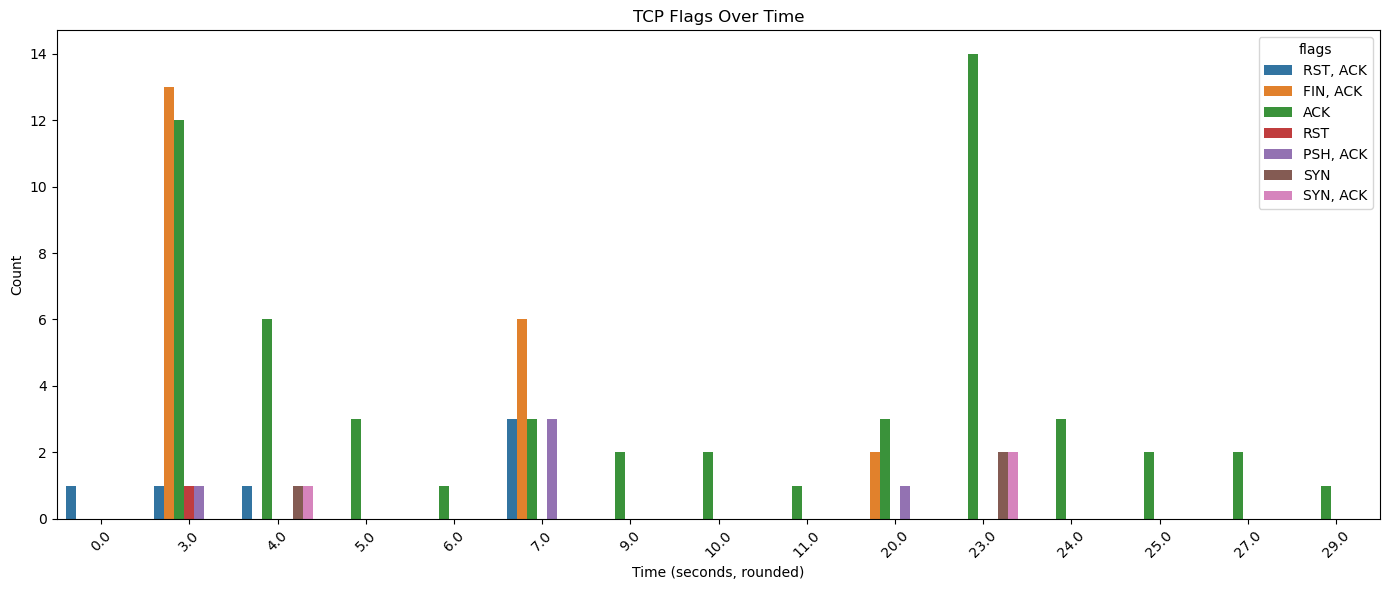

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.countplot(data=df, x='time_rounded', hue='flags')
plt.title("TCP Flags Over Time")
plt.xlabel("Time (seconds, rounded)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Select meaningful features
features = [
    'time', 'ACK', 'FIN', 'PSH', 'RST', 'SYN',
    'src_port_cat_unknown', 'dst_port_cat_dynamic', 'dst_port_cat_unknown',
    'dst_port_cat_well_known', 'direction_external', 'direction_inbound',
    'direction_outbound', 'timeofday_night'
]

X = df[features]
y = df['flag_encoded']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Accuracy
print("Accuracy:", model.score(X_test, y_test))


Accuracy: 0.9473684210526315
